In [1]:
import pandas as pd
import numpy as np
import imdb

%matplotlib inline

# Step 1 : Load ratings data
### A subset of 100,000 ratings from 700 users on 9,000 movies.

In [2]:
raw_ratings = pd.read_csv("the-movies-dataset/ratings_small.csv", dtype={"userId": int, "movieId": int, "rating": float})[["userId", "movieId", "rating"]]

In [3]:
raw_ratings.head()

,userId,movieId,rating
0,1,31,2.5
1,1,1029,3.0
2,1,1061,3.0
3,1,1129,2.0
4,1,1172,4.0


### Step 2:  Create a user rating vector for each movie Id

1. Determine largest user id in our data set. 
2. Create 'sparse' vectors with length equivalent to the number of possible users (largest user id)
3. Discard movies that are very sparse (do not have enough non-zero ratings)

In [4]:
#what is max user rating in our data set? --> this will be the size of our list for each set of user ratings for each movie.
N_user = max(raw_ratings.userId)
N_user

671

In [5]:
rating_matrix = pd.crosstab(raw_ratings.movieId, raw_ratings.userId, raw_ratings.rating, aggfunc='mean').fillna(0)

In [6]:
## SPARSITY THRESHOLD
threshold = int(.15 * N_user)
print("Sufficent User Rating Threshold: {} ratings".format(threshold))
# boolean mask of movies with sufficently dense ratings vectors.
mask = ((rating_matrix != 0).sum(axis = 1) > threshold).values

Sufficent User Rating Threshold: 100 ratings


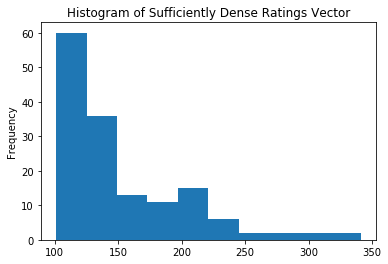

In [7]:
sufficientlyRated = rating_matrix.loc[mask,:]
(sufficientlyRated != 0).sum(axis = 1).plot(kind = "hist", title = "Histogram of Sufficiently Dense Ratings Vector")

### What does our transformed data look like now?

In [8]:
sufficientlyRated.shape

(149, 671)

In [9]:
sufficientlyRated.head()

userId,1,2,3,4,5,6,7,8,9,10,...,662,663,664,665,666,667,668,669,670,671
movieId,,,,,,,,,,,,,,,,,,,,,
1,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,4.0,0.0,...,0.0,4.0,3.5,0.0,0.0,0.0,0.0,0.0,4.0,5.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,5.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,4.0,0.0,5.0,4.0,0.0,0.0,0.0,0.0
10,0.0,4.0,0.0,4.0,0.0,0.0,3.0,0.0,0.0,0.0,...,3.0,0.0,0.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0
25,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,5.0,0.0


- Each row is a vector of user ratings for some movieId.
- Each column is a vector of a user's rating for each movie.

### Step 3: Similarity Matrix 
- Each cell is a pairwise similarity score.
- Possibile similarity scores:
    - Cosine Similarity
    - Pearson correlation coefficient

In [10]:
cosineSimMatrix = np.zeros(shape = (sufficientlyRated.shape[0], sufficientlyRated.shape[0]))
pearsonSimMatrix = np.zeros(shape = (sufficientlyRated.shape[0], sufficientlyRated.shape[0]))

In [11]:
def cosineSimilarity(a, b):
    denom = np.sqrt(np.square(a).sum()) * np.sqrt(np.square(b).sum())
    return a.dot(b) / denom

In [12]:
def pearsonSimilarity(a, b):
    diffA = a - np.mean(a)
    diffB = b - np.mean(b)
    return diffA.dot(diffB) / (np.sqrt(np.square(diffA).sum()) * np.sqrt(np.square(diffB).sum()))

In [13]:
cosineSimilarity(sufficientlyRated.loc[1], sufficientlyRated.loc[2])

0.39451145006593652

In [14]:
pearsonSimilarity(sufficientlyRated.loc[1], sufficientlyRated.loc[2])

0.22374218427303544

In [15]:
sufficientlyRated.index.values

array([    1,     2,     6,    10,    25,    32,    34,    36,    39,
          47,    50,   110,   111,   150,   153,   165,   185,   208,
         223,   231,   253,   260,   288,   292,   293,   296,   316,
         318,   329,   339,   344,   349,   356,   357,   364,   367,
         377,   380,   434,   454,   457,   480,   500,   527,   539,
         541,   586,   587,   588,   589,   590,   592,   593,   595,
         597,   608,   648,   733,   736,   750,   778,   780,   858,
         912,   919,   924,  1036,  1073,  1089,  1097,  1136,  1193,
        1196,  1197,  1198,  1200,  1206,  1208,  1210,  1213,  1214,
        1221,  1222,  1240,  1258,  1259,  1265,  1270,  1291,  1387,
        1393,  1517,  1527,  1580,  1617,  1682,  1704,  1721,  1732,
        1917,  1923,  1961,  1968,  2028,  2174,  2329,  2355,  2396,
        2502,  2571,  2628,  2683,  2706,  2716,  2762,  2791,  2797,
        2858,  2916,  2918,  2959,  2987,  2997,  3114,  3147,  3578,
        3793,  3996,

Populate matrix with pairwise cosine similarities:

In [16]:
for i in range(0,len(sufficientlyRated.index)):
    indexI = sufficientlyRated.index.values[i]
    for j in range(0, len(sufficientlyRated.index)):
        indexJ = sufficientlyRated.index.values[j]
        sim = cosineSimilarity(sufficientlyRated.loc[indexI], sufficientlyRated.loc[indexJ])
        cosineSimMatrix[i,j] = sim
        cosineSimMatrix[j,i] = sim

In [17]:
cosineSimMatrix[1,:]

array([ 0.39451145,  1.        ,  0.22200271,  0.41812374,  0.20339753,
        0.32134584,  0.3663719 ,  0.22540309,  0.35172378,  0.37914904,
        0.28680485,  0.42352215,  0.13295219,  0.42870421,  0.41899211,
        0.4121918 ,  0.44485639,  0.42433837,  0.30747562,  0.43852337,
        0.3810462 ,  0.26786752,  0.35563435,  0.45366917,  0.26316172,
        0.35129314,  0.4444796 ,  0.35733394,  0.39960639,  0.37613012,
        0.47567326,  0.38206499,  0.43593566,  0.35162508,  0.53035702,
        0.49460528,  0.47026504,  0.42988772,  0.38525371,  0.40306386,
        0.400228  ,  0.47162412,  0.54634788,  0.31585386,  0.42168227,
        0.22322008,  0.46682043,  0.47478714,  0.49399458,  0.40129433,
        0.38300032,  0.41274525,  0.37692291,  0.49412399,  0.43360708,
        0.25448293,  0.35564699,  0.34000935,  0.42299433,  0.17688228,
        0.24400506,  0.405881  ,  0.19096087,  0.16342706,  0.32110166,
        0.21416583,  0.28091131,  0.34722004,  0.21077859,  0.35

In [18]:
for i in range(0,len(sufficientlyRated.index)):
    indexI = sufficientlyRated.index.values[i]
    for j in range(0, len(sufficientlyRated.index)):
        indexJ = sufficientlyRated.index.values[j]
        sim = pearsonSimilarity(sufficientlyRated.loc[indexI], sufficientlyRated.loc[indexJ])
        pearsonSimMatrix[i,j] = sim
        pearsonSimMatrix[j,i] = sim

In [19]:
pearsonSimMatrix[1,:]

array([ 0.22374218,  1.        ,  0.08588917,  0.30668484,  0.06918922,
        0.14935791,  0.23350552,  0.0896371 ,  0.23023934,  0.22136862,
        0.10054578,  0.26965645, -0.0304444 ,  0.28451026,  0.30879753,
        0.28989388,  0.35058227,  0.32349319,  0.18386792,  0.31963639,
        0.26236932,  0.02677468,  0.24338961,  0.35702816,  0.11466512,
        0.1302616 ,  0.32965252,  0.14247787,  0.2915233 ,  0.27009763,
        0.35934312,  0.26695425,  0.25164122,  0.22807448,  0.41584287,
        0.38643702,  0.34611982,  0.28877077,  0.27961738,  0.29555847,
        0.2424976 ,  0.32037787,  0.44969419,  0.1174599 ,  0.31062455,
        0.05696906,  0.36445473,  0.3749858 ,  0.36564338,  0.23545879,
        0.22720438,  0.26650546,  0.17615702,  0.37733321,  0.31426898,
        0.04699162,  0.20773383,  0.20592338,  0.30204202,  0.03178047,
        0.09686631,  0.25226327, -0.02268493,  0.00659596,  0.19415379,
        0.0654879 ,  0.12494842,  0.20864493,  0.0515049 ,  0.21

### Associate our movies with their data to help us determine clustering quality

In [20]:
movieIdXexternalId = pd.read_csv("the-movies-dataset/links_small.csv")[["movieId", "imdbId"]]

In [21]:
movieIdXexternalId.shape

(9125, 2)

In [22]:
movieIdXexternalId.head()

,movieId,imdbId
0,1,114709
1,2,113497
2,3,113228
3,4,114885
4,5,113041


### Get the list of IMDB ratings for our subset of movies.

In [37]:
subset = movieIdXexternalId[movieIdXexternalId.movieId.isin(sufficientlyRated.index.values)]
subset.shape

(149, 2)

In [26]:
from imdb import IMDb

In [40]:
api = IMDb()
subset['title'] = subset.imdbId.apply(lambda mID: api.get_movie(str(mID)).data['title'])

/Users/cgels/anaconda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [41]:
subset

,movieId,imdbId,title
0,1,114709,Toy Story
1,2,113497,Jumanji
5,6,113277,Heat
9,10,113189,GoldenEye
24,25,113627,Leaving Las Vegas
31,32,114746,Twelve Monkeys
32,34,112431,Babe
34,36,112818,Dead Man Walking
37,39,112697,Clueless
45,47,114369,Se7en


In [42]:
import pickle

In [44]:
pickle.dump(file=open("cosineSimMat.pkl", "wb+"), obj=cosineSimMatrix)

In [ ]:
pickle.dump(file=open("cosineSimMat.pkl", "wb+"), obj=cosineSimMatrix)